In [21]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from keras.utils import plot_model 
import gensim


import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.layers import Attention, Conv1D, MaxPooling1D, Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
import nltk
nltk.download('stopwords')
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
from bs4 import BeautifulSoup 

[nltk_data] Downloading package stopwords to /Users/karen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load and clean data

In [2]:
df = pd.read_csv('Reviews.csv')
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [3]:
#get rid of NA 
df = df.dropna()

In [4]:
df = df[['Score', 'Summary','Text']]

In [5]:
df.head(15)

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...
5,4,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
#combine 'score' and 'Text' into one colum
df['text'] = df[['Summary', 'Text']].apply(lambda x: ' '.join(x), axis=1)
df = df[['Score','text']]
df.head(15)

,Score,text
0,5,Good Quality Dog Food I have bought several of...
1,1,Not as Advertised Product arrived labeled as J...
2,4,"""Delight"" says it all This is a confection tha..."
3,2,Cough Medicine If you are looking for the secr...
4,5,Great taffy Great taffy at a great price. The...
5,4,Nice Taffy I got a wild hair for taffy and ord...
6,5,Great! Just as good as the expensive brands! ...
7,5,"Wonderful, tasty taffy This taffy is so good. ..."
8,5,Yay Barley Right now I'm mostly just sprouting...
9,5,Healthy Dog Food This is a very healthy dog fo...


In [7]:
# send lables 
df.replace(1,0,True)
df.replace(2,0,True)
df.replace(3,1,True)
df.replace(4,2,True)
df.replace(5,2,True)

df.head(15)

,Score,text
0,2,Good Quality Dog Food I have bought several of...
1,0,Not as Advertised Product arrived labeled as J...
2,2,"""Delight"" says it all This is a confection tha..."
3,0,Cough Medicine If you are looking for the secr...
4,2,Great taffy Great taffy at a great price. The...
5,2,Nice Taffy I got a wild hair for taffy and ord...
6,2,Great! Just as good as the expensive brands! ...
7,2,"Wonderful, tasty taffy This taffy is so good. ..."
8,2,Yay Barley Right now I'm mostly just sprouting...
9,2,Healthy Dog Food This is a very healthy dog fo...


In [8]:
#stop word removal expect the words in the whitelist
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["don't", "not", "no","aren't","isn't","doesn't"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

In [9]:
df.text = df.text.apply(remove_stopwords)

In [10]:
df.head(15)

,Score,text
0,2,Good Quality Dog Food bought several Vitality ...
1,0,Not Advertised Product arrived labeled Jumbo S...
2,2,"""Delight"" says This confection around centurie..."
3,0,Cough Medicine If looking secret ingredient Ro...
4,2,Great taffy Great taffy great price. There wid...
5,2,Nice Taffy got wild hair taffy ordered five po...
6,2,Great! Just good expensive brands! This saltwa...
7,2,"Wonderful, tasty taffy This taffy good. It sof..."
8,2,Yay Barley Right I'm mostly sprouting cats eat...
9,2,Healthy Dog Food This healthy dog food. Good d...


In [11]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(df.text, df.Score, test_size=0.2, random_state=37)

In [40]:
MAX_X_TRAIN_10 = int(np.percentile([len(doc) for doc in X_train], 10))
MAX_X_TRAIN_50 = int(np.percentile([len(doc) for doc in X_train], 50))
MAX_X_TRAIN_90 = int(np.percentile([len(doc) for doc in X_train], 90))
print('10th Percentile Length:', MAX_X_TRAIN_10)
print('50th Percentile Length:', MAX_X_TRAIN_50)
print('90th Percentile Length:', MAX_X_TRAIN_90)

10th Percentile Length: 106
50th Percentile Length: 230
90th Percentile Length: 646


In [12]:
tk = Tokenizer(num_words= 40000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
#convert the text to a list of integer indexes
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

max_length = 60
x_train = pad_sequences(X_train_seq, maxlen=max_length, padding='post') 
x_test = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)



# Build embedding matrix

In [13]:
#load GloVe
glove_input_file = 'data/glove.twitter.27B.50d.txt'
word2vec_output_file = 'data/glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [14]:
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tk.word_index)+1, 50)) # +1 is because the matrix indices start with 0
for word, i in tk.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
            #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
            #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
            #Wi:the ith row of embeddings_matrix

del embeddings

# Build BiLSTM Model (Model_1)

In [15]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tk.word_index)+1,
                          output_dim=50,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))
#mask_zero is to deal with padding problem
#model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer1'))) #bi(lstm)
model_1.add(Bidirectional(LSTM(50, return_sequences=False, name='Bidrectional_lstm_layer1')))
#model_1.add(BatchNormalization())
model_1.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model_1.add(Dense(3, activation='softmax', name='output_layer'))

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          6313900   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 3)                 303       
Total params: 6,354,603
Trainable params: 6,354,603
Non-trainable params: 0
_________________________________________________________________


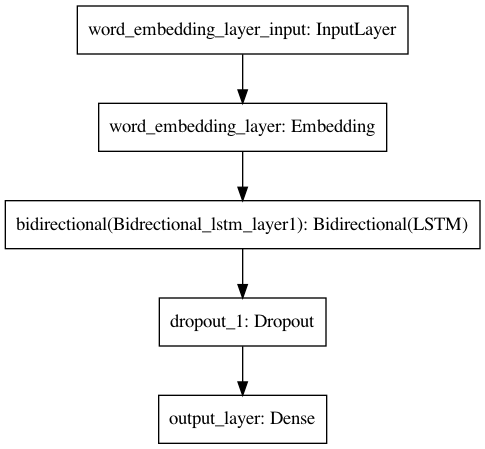

In [17]:
plot_model(model_1, to_file='model_1.png',show_shapes=False)

# Train model_1

In [19]:
def bilstm_model(model_1):
    model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    history_1 = model_1.fit(x_train, y_train_oh,
          batch_size=32,
          epochs=3,
         validation_split = 0.2)

    scoress = model_1.evaluate(x_test, y_test_oh)
    print("%s: %.2f%%"%(model_1.metrics_names[1], scoress[1]*100))
    
    return history_1

In [20]:
history_1 = bilstm_model(model_1)#12

Epoch 1/3
11369/11369 [==============================] - 1445s 127ms/step - loss: 0.3529 - accuracy: 0.8705 - val_loss: 0.2833 - val_accuracy: 0.8927
Epoch 2/3
11369/11369 [==============================] - 4094s 360ms/step - loss: 0.2692 - accuracy: 0.9011 - val_loss: 0.2581 - val_accuracy: 0.9042
Epoch 3/3
3553/3553 [==============================] - 40s 11ms/step - loss: 0.2581 - accuracy: 0.9066
accuracy: 90.66%


# Model_1 prediction

In [22]:
y_preds_1 = model_1.predict(x_test)

In [26]:
outputs_1 = [np.argmax(p) for p in y_preds_1]

In [30]:
confusion_matrix(y_test,outputs_1,labels=[0, 1, 2])

array([[13906,  1062,  1626],
       [ 2076,  3585,  2750],
       [ 1503,  1596, 85579]])

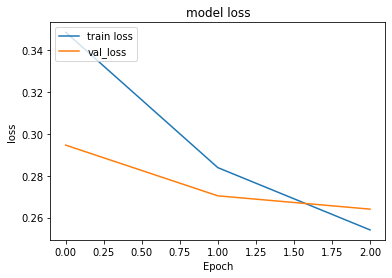

In [83]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val_loss'], loc='upper left')
plt.show()

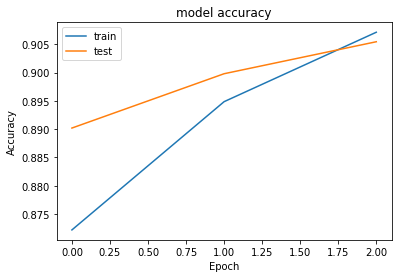

In [89]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Build CNN_LSTM model (model_2)

In [31]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tk.word_index)+1,input_length = 60,
                              output_dim=50,
                              weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                              mask_zero=True)) # trainable=True results in overfitting

model_2.add(Dropout(0.6))
model_2.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_2.add(BatchNormalization())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(3, activation='softmax', name='output_layer'))   

In [32]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 60, 50)            6313900   
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            8032      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)              

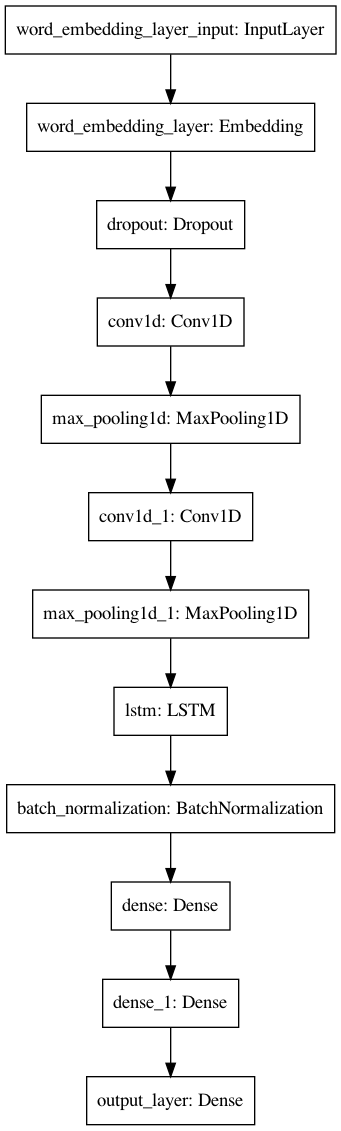

In [38]:
plot_model(model_2, to_file='model_2.png')

# Train model_2

In [33]:
def cnn_model(model_2):
    model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    history_2= model_2.fit(x_train, y_train_oh,
          batch_size=32,
          epochs=5,
         validation_split = 0.2)
    
    scoress = model_1.evaluate(x_test, y_test_oh)
    print("%s: %.2f%%"%(model_1.metrics_names[1], scoress[1]*100))
    
    return history_2

In [34]:
history_2 = cnn_model(model_2)

Epoch 1/5
11369/11369 [==============================] - 1333s 117ms/step - loss: 0.4069 - accuracy: 0.8511 - val_loss: 0.3163 - val_accuracy: 0.8809
Epoch 2/5
11369/11369 [==============================] - 1449s 127ms/step - loss: 0.3291 - accuracy: 0.8773 - val_loss: 0.2941 - val_accuracy: 0.8895
Epoch 3/5
11369/11369 [==============================] - 1507s 133ms/step - loss: 0.3043 - accuracy: 0.8862 - val_loss: 0.2866 - val_accuracy: 0.8947
Epoch 4/5
11369/11369 [==============================] - 1543s 136ms/step - loss: 0.2892 - accuracy: 0.8916 - val_loss: 0.2733 - val_accuracy: 0.8981
Epoch 5/5
3553/3553 [==============================] - 41s 11ms/step - loss: 0.2581 - accuracy: 0.9066
accuracy: 90.66%


# Model_2 prediction

In [35]:
y_preds_2 = model_2.predict(x_test)

In [36]:
outputs_2 = [np.argmax(p) for p in y_preds_2]

In [37]:
confusion_matrix(y_test,outputs_2,labels=[0, 1, 2])

array([[13005,   920,  2669],
       [ 1931,  2235,  4245],
       [  960,   804, 86914]])

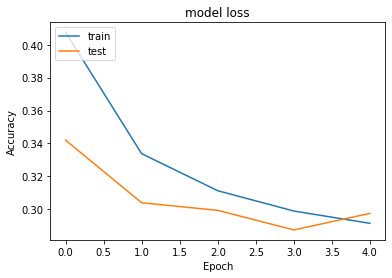

In [137]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

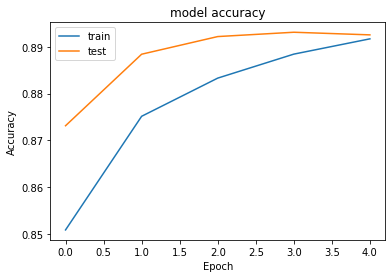

In [125]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()